# Imports

In [1]:
from pdb import set_trace

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

In [3]:
import arms

# Part 1 : Stochastic Multi-Armed Bandits on Simulated Data

In [4]:
class UCB:
    
    def __init__(self):
        pass
    
    def plotCB(self):
        plt.figure()
        plt.errorbar(np.arange(self.K), self.mu, yerr=self.UCB, fmt='r.')
        plt.show()

class UCB1(UCB):
    
    def __init__(self, mab, T = 5000, rho = 0.5):
        
        K = len(mab)

        draws   = np.empty(T)
        rewards = np.empty(T)
        
        # Initialization
        S = np.array([float(arm.sample()) for arm in mab])
        N = np.ones(K)
        
        draws[:K] = np.arange(K)
        rewards[:K] = S[:K]
        
        for t in range(K, T):
            
            # Calculate the upper confidence bound
            UCB = rho * np.sqrt(np.log(t) / (2.0 * N))
            A = np.argmax(S / N + UCB)
            R = float(mab[A].sample())
            
            # Update parameters
            N[A] += 1
            S[A] += R
            
            # Fill history
            draws[t]   = A
            rewards[t] = R

        self.K = K
        self.N = N
        self.S = S
        self.mu = S / N
        self.UCB = UCB
        self.draws = draws
        self.rewards = rewards

class TS:
    def __init__(self, mab, T = 5000):
        
        K = len(mab)
        
        S = np.zeros(K)
        N = np.zeros(K)
        
        draws   = np.empty(T)
        rewards = np.empty(T)
        
        for t in range(T):
            
            sample = np.random.beta(S + 1, N - S + 1)
            A = np.argmax(sample)
            
            # Bernoulli bandit TS (Old version)
            # R = float(mab[A].sample())
            
            # General TS (Agrawal Goyal 2012)
            p = float(mab[A].sample())
            R = float(np.random.binomial(1, p))
            
            N[A] += 1
            S[A] += R
            
            draws[t]   = A
            rewards[t] = R
            
        self.K = K
        self.N = N
        self.S = S
        self.mu = S / N
        self.draws = draws
        self.rewards = rewards

def LaiRobbinsLB(means):
    KL = lambda x, y : x * np.log(x / y) + (1 - x) * np.log((1.0 - x) / (1.0 - y))
    mu_max = np.max(means)
    no_means = means[means < mu_max]
    return np.sum((mu_max - no_means) / KL(no_means, mu_max))

## Plotting functions

In [6]:
import scipy.stats as sp

def plot_arm_exp(arm, ax, **args):
    x=np.arange(0, arm.B, 0.01)
    y=sp.expon.pdf(x, scale=arm.L)
    
    ax.fill_between(x, y, **args)
    ax.set_title("Exponential (L = %.2f)" % arm.L)
    
def plot_arm_bernoulli(arm, ax, **args):
    
    ax.bar([0, 1], [1 - arm.p, arm.p], 0.1, **args)
    ax.set_ylim([0, 1])
    ax.set_title("Bernoulli (p = %.2f)" % arm.p)

def plot_arm_finite(arm, ax, **args):

    ax.bar(arm.X, arm.P, 0.1, **args)
    ax.set_ylim([0, 1])
    ax.set_title("Finite")

def plot_arm_beta(arm, ax, **args):
    x=np.arange(0, 1, 0.01)
    y=sp.beta.pdf(x, arm.a, arm.b)
    
    ax.fill_between(x, y, **args)    
    ax.set_title("Beta (a = %.2f, b = %.2f)" % (arm.a, arm.b))

    
arms.ArmFinite.plot_pdf = plot_arm_finite
arms.ArmBeta.plot_pdf = plot_arm_beta
arms.ArmBernoulli.plot_pdf = plot_arm_bernoulli
arms.ArmExp.plot_pdf = plot_arm_exp


def print_mab_infos(MAB):
    means = np.array([el.mean for el in MAB])
    C = LaiRobbinsLB(means)

    print('Bernouilli bandit:')
    print('  means:', means)
    print('  complexity:', C)
    
    
def plot_mab_means(MAB, colors=None):
    means = np.array([arm.mean for arm in MAB])
    #lt.bar(np.arange(len(means)), means)
    #lt.show()
    
    fig, ax = plt.subplots(figsize=(6,5))
    rects = ax.bar(np.arange(len(means)), means, color=colors)
    width = rects[0].get_width()

    ax.set_ylabel('Arms means')
    ax.set_ylim([0, 1])
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(['Arm %d' % i for i in np.arange(len(means))])
    
    for rect in rects:
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*rect.get_height(),
                '%.2f' % rect.get_height(),
                ha='center', va='bottom')

def plot_mab_arms(MAB, colors=None):
    fig, ax = plt.subplots(len(MAB), 1, sharex=True, figsize=(6, 8))
    for i, arm in enumerate(MAB):
        arm.plot_pdf(ax[i], color=colors[i])

def plot_lai_robbins_c(MAB, T = 5000):
    x = np.arange(1, T+1)
    means = np.array([el.mean for el in MAB])
    C = LaiRobbinsLB(means)
    plt.plot(x, C * np.log(x), label='Lai & Robbins lower bound', color='r', dashes=[5, 5])
    
def plot_mab_regret(MAB, T = 5000, simulations = 1000):
    K = len(MAB)
    means = np.array([el.mean for el in MAB])
    mu_max = np.max(means)

    reg1 = np.zeros(T)
    reg2 = np.zeros(T)
    for i in tqdm(range(simulations), desc="Simulating"):
        ucb1 = UCB1(MAB, T, rho=0.5)
        ts = TS(MAB, T)

        reg1 += mu_max * np.arange(1, T + 1) - np.cumsum(ucb1.rewards)
        reg2 += mu_max * np.arange(1, T + 1) - np.cumsum(ts.rewards)

    reg1 /= simulations
    reg2 /= simulations

    x = np.arange(1, T+1)

    plt.plot(x, reg1, label='UCB1')
    plt.plot(x, reg2, label='Thompson')
    plt.xlabel('Rounds')
    plt.ylabel('Estimated expected cumulative Regret')
    plt.legend()


## Bernoulli bandit

Bernouilli bandit:
  means: [ 0.64  0.18  0.8   0.81  0.29]
  complexity: 34.8245098313


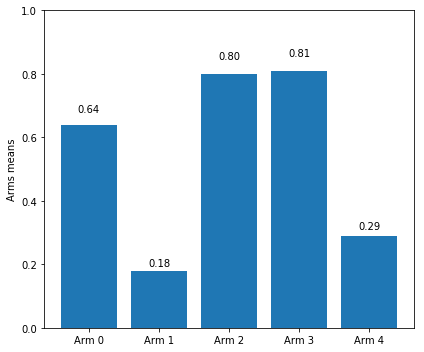

Simulating: 100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]


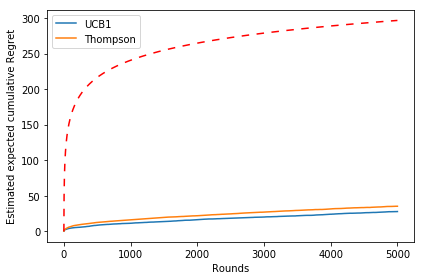

In [7]:
random_state = np.random.randint(1, 312414)

MAB1 = [
    arms.ArmBernoulli(0.28, random_state=random_state),
    arms.ArmBernoulli(0.29, random_state=random_state),
    arms.ArmBernoulli(0.35, random_state=random_state),
    arms.ArmBernoulli(0.80, random_state=random_state),
]

MAB2 = [
    arms.ArmBernoulli(0.64, random_state=random_state),
    arms.ArmBernoulli(0.18, random_state=random_state),
    arms.ArmBernoulli(0.8, random_state=random_state),
    arms.ArmBernoulli(0.81, random_state=random_state),
    arms.ArmBernoulli(0.29, random_state=random_state),
]

MAB = MAB2

print_mab_infos(MAB)

# Plot means
plot_mab_means(MAB)

#plt.tight_layout()
#plt.savefig('../imgs/ex1_bernoulli_arms.svg')
plt.show()

# Plot regret and bound
plot_mab_regret(MAB, T=5000, simulations=1000)
plot_lai_robbins_c(MAB)

#plt.tight_layout()
#plt.savefig('../imgs/ex1_bernoulli_regret.svg')
plt.show()


## Choice of rho

10it [01:39,  9.97s/it]


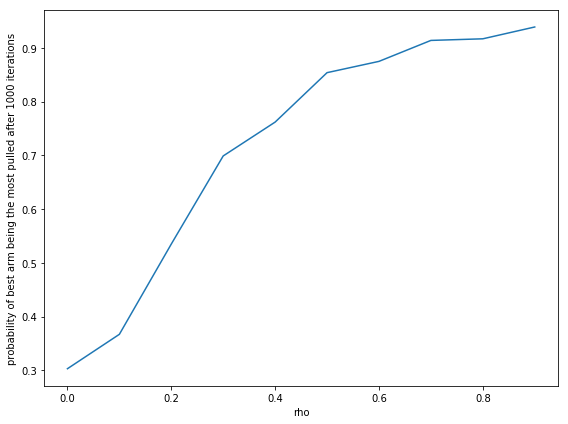

In [10]:
random_state = np.random.randint(1, 312414)

MAB = [
    arms.ArmBernoulli(0.20, random_state=random_state),
    arms.ArmBernoulli(0.25, random_state=random_state),
    arms.ArmBernoulli(0.30, random_state=random_state),
    arms.ArmBernoulli(0.35, random_state=random_state),
]

T = 1000
K = len(MAB)
means = np.array([el.mean for el in MAB])
best_arm = np.argmax(means)
mu_max = np.max(means)

rhos = np.arange(0, 1, 0.1)
succ = np.empty((len(rhos), 1000), dtype=bool)

for ir, rho in tqdm(enumerate(rhos)):
    for it in range(1000):
        ucb1 = UCB1(MAB, T, rho)
        succ[ir, it] = (np.argmax(ucb1.N) == best_arm)

succ_ratio = np.mean(succ, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(rhos, succ_ratio)
plt.xlabel("rho")
plt.ylabel("probability of best arm being the most pulled after 1000 iterations")
#plt.tight_layout()
#plt.savefig("../imgs/_ex1_success_ratio.svg")
plt.show()

## General bandit

Bernouilli bandit:
  means: [ 0.28        0.47586714  0.53        0.28571429]
  complexity: 13.1672037082


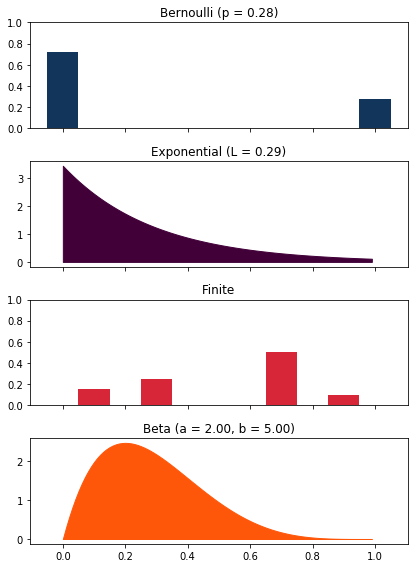

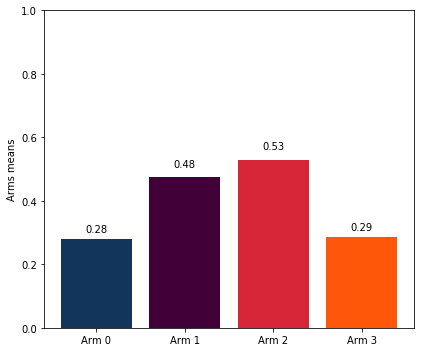

Simulating: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


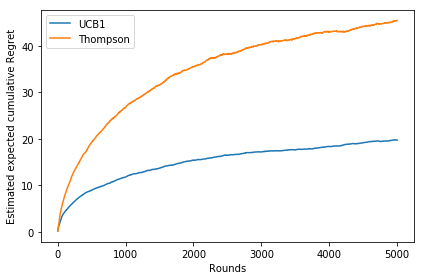

In [11]:
random_state = np.random.randint(1, 312414)

MAB = [
    arms.ArmBernoulli(0.28, random_state=random_state),
    arms.ArmExp(0.29, random_state=random_state),
    arms.ArmFinite(
        np.array([0.1, 0.3, 0.7, 0.9]),
        np.array([0.15, 0.25, 0.5, 0.1]),
        random_state=random_state),
    arms.ArmBeta(2, 5, random_state=random_state),
]

colors=["#12355b", "#420039", "#d72638", "#ff570a"]

print_mab_infos(MAB)

# Plot arms
plot_mab_arms(MAB, colors)

#plt.tight_layout()
#plt.savefig("../imgs/_ex1_arms_pdf.svg")
plt.show()

# Plot means
plot_mab_means(MAB, colors)

#plt.tight_layout()
#plt.savefig('../imgs/_ex1_general_arms.svg')
plt.show()

# Plot regret and bound
plot_mab_regret(MAB, T=5000, simulations=1000)

#plt.tight_layout()
#plt.savefig('../imgs/_ex1_general_regret.svg')
plt.show()

# Part 2 Linear Bandit on Real Data

In [12]:
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel

In [13]:
class RandomPolicy:
    
    def __init__(self, T = 6000):
        d = model.n_features

        regret = np.empty(T)
        draws = np.empty(T, dtype=int)
        sq_dist = np.empty(T)
                
        for t in range(T):
            a_t = np.random.randint(d) # Initial action
            r_t = model.reward(a_t)
            
            regret[t] = model.best_arm_reward() - r_t
            draws[t] = a_t

        self.draws = draws
        self.regret = regret
        
class EpsilonGreedy:
    
    def __init__(self, T = 6000, eps=0.1):
        n_a = model.n_actions
        d = model.n_features

        regret = np.empty(T)
        draws = np.empty(T, dtype=int)
        sq_dist = np.empty(T)

        explore = np.random.binomial(1, eps, T)
        
        # Initialization
        S = np.squeeze(np.array([model.reward(i) for i in range(n_a)]))
        N = np.ones(n_a)
        draws[:n_a] = np.arange(n_a)
        regret[:n_a] = model.best_arm_reward() - S
        sq_dist[:n_a] = np.nan
        

        W = np.linalg.pinv(model.features)

        for t in range(d, T):
            
            if explore[t]:
                a_t = np.random.randint(d) # Initial action
            else:
                a_t = np.argmax(S / N)
                
            r_t = model.reward(a_t)
            S[a_t] += r_t
            N[a_t] += 1
            
            regret[t] = model.best_arm_reward() - r_t
            draws[t] = a_t
                        
            theta = np.dot(W, S / N)
            sq_dist[t] = np.sum((theta - model.real_theta)**2)

        self.draws = draws
        self.regret = regret        
        self.sq_dist = sq_dist
        
class linUCBnaive:

    def __init__(self, T = 6000, alpha = 1.0, regul = 1.0):
        d = model.n_features

        draws = np.empty(T, dtype=int)
        regret = np.empty(T)
        sq_dist = np.empty(T)
        
        Z = np.empty((T, d))
        Y = np.empty(T)

        u_new = np.zeros(d)

        a_t = np.random.randint(d) # Initial action
        for t in range(T):

            phi_t = model.features

            r_t = model.reward(a_t)
            Y[t] = r_t
            Z[t, :] = phi_t[a_t, :]

            W = np.linalg.inv(np.dot(Z[:t+1].T, Z[:t+1]) + regul * np.identity(d))
            u_new = np.dot(W, np.dot(Z[:t+1].T, Y[:t+1]))
            b_t = alpha * np.sqrt(np.sum(np.dot(phi_t, W) * phi_t, axis=1))

            draws[t] = a_t
            regret[t] = model.best_arm_reward() - r_t
            sq_dist[t] = np.sum((u_new - model.real_theta) **2)
            
            # Determine next action
            a_t = np.argmax(np.dot(phi_t, u_new) + b_t)

        self.draws = draws
        self.regret = regret
        self.sq_dist = sq_dist
            
            
class linUCBfast:

    def __init__(self, T = 6000, alpha = 1.0, regul = 1.0):
        d = model.n_features

        draws = np.empty(T, dtype=int)
        regret = np.empty(T)
        sq_dist = np.empty(T)
        
        W = regul * np.identity(d)
        V = np.zeros(d)
        
        u_new = np.zeros(d)

        # Take the first action at random
        a_t = np.random.randint(d)
        for t in range(T):

            phi_t = model.features

            r_t = model.reward(a_t)
            
            W += phi_t[a_t][None,:] * phi_t[a_t][:,None]
            Winv = np.linalg.inv(W)
            
            V += r_t * phi_t[a_t]
            
            u_new = np.dot(Winv, V)
            b_t = alpha * np.sqrt(np.sum(np.dot(phi_t, Winv) * phi_t, axis=1))

            draws[t] = a_t
            regret[t] = model.best_arm_reward() - r_t
            sq_dist[t] = np.sum((u_new - model.real_theta) **2)
            
            # Determine next action
            a_t = np.argmax(np.dot(phi_t, u_new) + b_t)

        self.draws = draws
        self.regret = regret
        self.sq_dist = sq_dist
            

## Comparison of the algorithms

Simulating: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


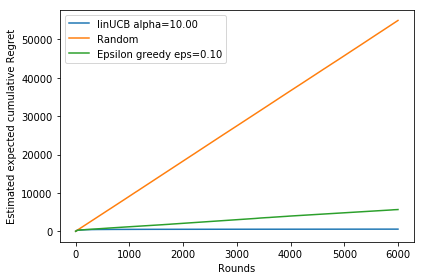

Estimation of the distance to real theta at Tmax : 0.31


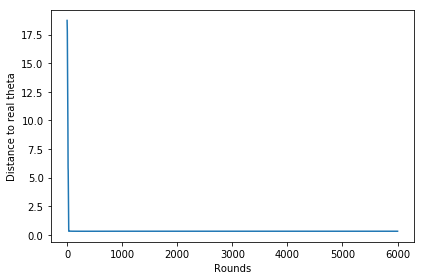

In [15]:
random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)

n_a = model.n_actions
d = model.n_features

T = 6000
nb_simu = 10
regul = 0.1
alpha = 10

eps = 0.1

reg1 = np.zeros(T)
reg2 = np.zeros(T)
reg3 = np.zeros(T)

sqdist = np.zeros(T)

for i in tqdm(range(nb_simu), desc="Simulating"):
    linucb = linUCBfast(T, alpha, regul)
    reg1 += linucb.regret
    sqdist += linucb.sq_dist
    
    randp = RandomPolicy(T)
    reg2 += randp.regret

    epspol = EpsilonGreedy(T, eps=eps)
    reg3 += epspol.regret
    
reg1 /= nb_simu
reg2 /= nb_simu
reg3 /= nb_simu

sqdist /= nb_simu

x = np.arange(1, T+1)

plt.figure(1)
plt.plot(x, np.cumsum(reg1), label=('linUCB alpha=%.2f' % alpha))
plt.plot(x, np.cumsum(reg2), label=('Random'))
plt.plot(x, np.cumsum(reg3), label=('Epsilon greedy eps=%.2f' % eps))
plt.xlabel('Rounds')
plt.ylabel('Estimated expected cumulative Regret')
plt.legend()
#plt.tight_layout()
#plt.savefig('../imgs/_ex2_comp_regret.svg')
plt.show()


print("Estimation of the distance to real theta at Tmax : %.2f" % sqdist[-1])

plt.figure(2)
plt.plot(x, sqdist)
plt.xlabel('Rounds')
plt.ylabel('Distance to real theta')
#plt.tight_layout()
#plt.savefig('../imgs/_ex2_linUCB_dist.svg')
plt.show()


## Impact of alpha

Simulating linUCB: 100%|██████████| 5/5 [01:27<00:00, 17.43s/it]
Simulating epsGreedy: 0it [00:00, ?it/s]


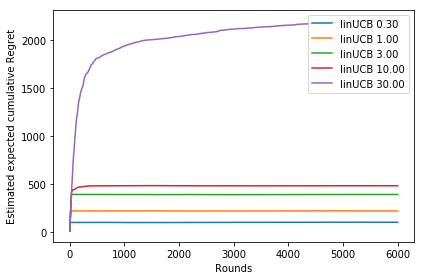

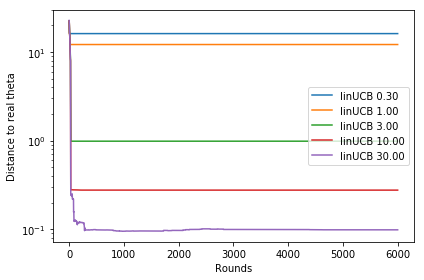

In [16]:
random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)

n_a = model.n_actions
d = model.n_features

T = 6000
nb_simu = 20

# linUCB parameters
regul = 0.1
alphas = [0.3, 1, 3, 10, 30]

# Epsilon greedy parameters
epsilons = []

reg = np.zeros(T)
sqdist = np.zeros(T)

x = np.arange(1, T+1)

for alpha in tqdm(alphas, desc="Simulating linUCB"):
    for i in range(nb_simu):
        linucb = linUCBfast(T, alpha, regul)
        reg += linucb.regret
        sqdist += linucb.sq_dist
    reg /= nb_simu
    sqdist /= nb_simu
    
    plt.figure(1)
    plt.plot(x, np.cumsum(reg), label=('linUCB %.2f' % alpha))

    plt.figure(2)
    plt.semilogy(x, sqdist, label=('linUCB %.2f' % alpha))

    
for eps in tqdm(epsilons, desc="Simulating epsGreedy"):
    for i in range(nb_simu):
        epspol = EpsilonGreedy(T, eps=eps)
        reg += epspol.regret
    reg /= nb_simu

    plt.figure(1)
    plt.plot(x, np.cumsum(reg), label=('Epsilon greedy %.2f' % eps))

    
plt.figure(1)
plt.xlabel('Rounds')
plt.ylabel('Estimated expected cumulative Regret')
plt.legend(loc='upper right')
#plt.tight_layout()
#plt.savefig("../imgs/_ex2_linUCB_alpha_regret.svg")

plt.figure(2)
plt.xlabel('Rounds')
plt.ylabel('Distance to real theta')
plt.legend(loc='center right')
#plt.tight_layout()
#plt.savefig("../imgs/_ex2_linUCB_alpha_dist.svg")


plt.show()

In [30]:
random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)

n_a = model.n_actions
d = model.n_features

T=1000
nb_simu = 100
perc = 0;

tries = np.zeros(n_a)
for _ in tqdm(range(nb_simu)):
    linucb = linUCBfast(T, alpha=1.0,regul=0.1)
    draws = np.bincount(linucb.draws)
    perc += (np.argmax(draws) == np.argmax(np.dot(model.features, model.real_theta)))
    draws[np.argmax(draws)] = 0
    tries[:len(draws)] += draws

print('Optimal arm : %.2f%% of the iterations' % (100 * perc / nb_simu))
print('Average number of draws before convergence : %.2f' % (np.sum(tries) / nb_simu))

100%|██████████| 100/100 [00:14<00:00,  6.95it/s]

Optimal arm : 100.00% of the iterations
Average number of draws before convergence : 10.41
